# 决策树

In [2]:
import pandas as pd
import numpy as np

In [3]:
#读入数据
def read_arrf(file):
    with open(file, encoding="utf-8") as f:
        header = []
        for line in f:
            if line.startswith("@attribute"):
                header.append(line.split()[1].replace("'", ""))
            elif line.startswith("@data"):
                break
        df = pd.read_csv(f, header = None)
        df.columns = header
    return df

train = read_arrf('NSL-KDD/KDDTrain+.arff')
test = read_arrf('NSL-KDD/KDDTest+.arff')
train

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,...,25,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
125969,8,udp,private,SF,105,145,0,0,0,0,...,244,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,normal
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,...,30,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,normal
125971,0,tcp,klogin,S0,0,0,0,0,0,0,...,8,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly


In [4]:
# 数据预处理
def preprocess_data(train, test):
    # 选出字符型和数值型的列
    str_cols = train.select_dtypes(include=['object']).columns
    real_cols = train.select_dtypes(include=['int', 'float64']).columns
    
    # 创建一个字典，将每个唯一值映射到一个整数
    unique_vals = {}
    for c in str_cols:
        unique = train[c].unique()
        for i, val in enumerate(unique):
            unique_vals[val] = i
    
        # 使用字典将分类变量进行编码
        train[c] = train[c].apply(lambda x: unique_vals[x])
        test[c] = test[c].apply(lambda x: unique_vals[x])
    
    # 定义一个函数，将数值型变量进行分桶处理
    def bucketize(col, n_bins=5):
        # 将变量按照值的大小进行排序
        col_sorted = sorted(col)
        n = len(col_sorted)
        # 计算每个分桶的大小
        bucket_size = n // n_bins
        # 初始化分桶边界
        boundaries = [col_sorted[0]]
        # 将每个分桶的边界加入到列表中
        for i in range(1, n_bins):
            boundary_index = i * bucket_size
            boundaries.append(col_sorted[boundary_index])
        boundaries.append(col_sorted[-1])
        # 将每个数值型变量的值根据分桶边界进行编码
        col_bucketized = []
        for x in col:
            for i in range(1, len(boundaries)):
                if x <= boundaries[i]:
                    col_bucketized.append(i-1)
                    break
        return col_bucketized
    
    # 对每个数值型变量进行分桶处理
    for c in real_cols:
        train[c] = bucketize(train[c], n_bins=5)
        test[c] = bucketize(test[c], n_bins=5)
    
    return train, test
train, test = preprocess_data(train, test)
train


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,0,0,0,4,0,0,0,0,0,...,2,2,2,4,0,0,0,4,0,0
1,0,1,1,0,2,0,0,0,0,0,...,0,0,4,4,0,0,0,0,0,0
2,0,0,2,1,0,0,0,0,0,0,...,2,1,2,0,0,3,3,0,0,1
3,0,0,3,0,3,4,0,0,0,0,...,3,3,0,3,4,3,3,0,4,0
4,0,0,3,0,3,3,0,0,0,0,...,3,3,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,0,2,1,0,0,0,0,0,0,...,2,1,3,0,0,3,3,0,0,1
125969,4,1,2,0,2,3,0,0,0,0,...,3,2,1,2,0,0,0,0,0,0
125970,0,0,15,0,4,3,0,0,0,0,...,2,2,3,0,0,3,0,4,0,0
125971,0,0,35,1,0,0,0,0,0,0,...,1,0,2,0,0,3,3,0,0,1


In [5]:
class DecisionTreeDiscrete:
    def __init__(self,Data):
        self.Data = Data
        self.feature_value=dict([(feature, list(pd.unique(self.Data[feature]))) for feature in self.Data.iloc[:, :-1].columns])

    def Entropy(self,Data):
        label = Data.iloc[:, -1]
        label_class = label.value_counts()  
        Ent = 0
        for k in label_class.keys():
            p_k = label_class[k] / len(label)
            Ent += -p_k * np.log2(p_k)
        return Ent

    def InfoGain(self,Data,feature):
        Ent = self.Entropy(Data)
        feature_value = Data[feature].value_counts()  
        gain = 0

        for v in feature_value.keys():
            ratio = feature_value[v] / Data.shape[0]
            Ent_v = self.Entropy(Data.loc[Data[feature] == v])

            gain += ratio * Ent_v
        return Ent - gain
    
    def SplitData(self,Data,feature,value):
        datasize = Data.shape[0]
        newData = pd.DataFrame(columns=Data.columns)
        for i in range(datasize):
            if Data.iloc[i][feature]==value:
                newData = newData.append(Data.iloc[i,:],ignore_index=True)
        newData.drop([feature],axis=1,inplace=True)
        return newData

    def MajorClass(self,Data):
        label = Data.iloc[:, -1]
        label_sort = label.value_counts(sort=True)
        return label_sort.keys()[0]


    def ChooseBestFeature(self,Data):
        res={}
        features = Data.columns[:-1]
        for fea in features:
            temp=self.InfoGain(Data,fea)
            res[fea]=temp
        res = sorted(res.items(), key=lambda x: x[1], reverse=True)
        return res[0][0]  

    def TreeGenerate(self,Data):
        label = Data.iloc[:, -1]
        #Data中样本同属同一类别
        if len(label.value_counts()) == 1:  
            return label.values[0]
        # 所有样本在所有属性上取值相同
        if all(len(Data[i].value_counts()) == 1 for i in Data.iloc[:, :-1].columns):
            return self.MajorClass(Data)
        #属性集为空
        if len(Data.columns)==1:
            return self.MajorClass(Data)

        best_feature= self.ChooseBestFeature(Data)  
        Tree = {best_feature: {}}
        #样本集为空
        exist_vals = pd.unique(Data[best_feature])  
        if len(exist_vals) != len(self.feature_value[best_feature]):  
            no_exist_attr = set(self.feature_value[best_feature]) - set(exist_vals)
            for no_feat in no_exist_attr:
                Tree[best_feature][no_feat] = self.MajorClass(Data)
        #递归创建子树
        for item in pd.unique(Data[best_feature]):  
            d = Data.loc[Data[best_feature] == item]
            del (d[best_feature])
            Tree[best_feature][item] = self.TreeGenerate(d)
        return Tree
    def predict(self, Tree, test_data):
        first_feature = list(Tree.keys())[0]
        second_dict = Tree[first_feature]
        class_label = 1 # 初始化为1
        for key in second_dict.keys():
            if test_data[first_feature] == key:
                if type(second_dict[key]).__name__ == 'dict':
                    class_label = self.predict(second_dict[key], test_data)
                else:
                    class_label = second_dict[key]
        return class_label

    #计算验证集准确数
    def accuracy(self,Tree,valdata):
        label = list(valdata.iloc[:,-1])
        num = valdata.shape[0]
        Preds = []
        correct_count = 0
        for i in range(num):
            pred = self.predict(Tree,valdata.iloc[i,:])
            Preds.append(pred)
            if label[i]==pred:
                correct_count+=1
        return correct_count   

In [6]:
# 创建一个DecisionTreeDiscrete实例
dt = DecisionTreeDiscrete(train)
tree = dt.TreeGenerate(train)
tree

{'service': {0: {'flag': {5: 0,
    0: {'dst_host_diff_srv_rate': {2: {'dst_host_srv_diff_host_rate': {0: {'dst_host_count': {1: 0,
          2: {'srv_count': {1: {'src_bytes': {1: 0,
              4: {'dst_host_rerror_rate': {4: 0,
                0: {'dst_host_srv_serror_rate': {0: {'logged_in': {3: {'duration': {0: {'srv_diff_host_rate': {3: 0,
                        0: {'dst_host_same_src_port_rate': {0: 0,
                          2: 0,
                          4: {'diff_srv_rate': {3: 0,
                            0: {'num_root': {0: {'num_access_files': {0: 0,
                                4: 0}},
                              4: 0}},
                            4: 0}},
                          3: 0}},
                        4: 0}},
                      4: 0}},
                    0: 0}},
                  3: 0}}}},
              3: 0,
              2: 0,
              0: 0}},
            2: 0,
            0: {'src_bytes': {1: 0,
              4: {'logged_in': {3: {'dst

In [7]:
# 测试并输出准确率
acc = dt.accuracy(tree, test) / test.shape[0]
acc

0.784111071682044

# 投毒攻击

In [8]:
import matplotlib.pyplot as plt

# 投毒率
poison_rates = [0, 10, 20, 30, 40, 50, 60 , 70, 80, 90, 100]

# 创建一个DecisionTreeDiscrete实例
dt = DecisionTreeDiscrete(train)

# 存储不同投毒率下的准确率
accuracy_list = []

# 生成决策树并计算准确率
for rate in poison_rates:
    # 创建一个副本用于投毒
    modified_data = train.copy()
    
    # 计算要抽取的数据的数量
    num_samples = int(rate / 100 * len(train))

    
    # 抽取对应投毒率的数据
    subset_df = modified_data.sample(n=num_samples, random_state=42).copy()
    
    # 将最后一列标签互换
    subset_df['class'] = subset_df['class'].apply(lambda x: 'normal' if x == 'anomaly' else 'anomaly')
    
    # 合并原始数据和修改后的数据
    modified_data = pd.concat([train, subset_df], ignore_index=True)
    
    # 生成决策树
    tree = dt.TreeGenerate(modified_data)
    
    # 测试并计算准确率
    acc = dt.accuracy(tree, test) / test.shape[0]

    # 输出准确率
    print(f"Poison Rate: {rate}%, Accuracy: {acc}")
    
    # 将准确率添加到列表中
    accuracy_list.append(acc)



Poison Rate: 0%, Accuracy: 0.784111071682044
Poison Rate: 10%, Accuracy: 0.7904542228530873
Poison Rate: 20%, Accuracy: 0.7989709013484741
Poison Rate: 30%, Accuracy: 0.7934705464868701
Poison Rate: 40%, Accuracy: 0.7977288857345636
Poison Rate: 50%, Accuracy: 0.779764017033357
Poison Rate: 60%, Accuracy: 0.758915897799858
Poison Rate: 70%, Accuracy: 0.7647267565649397
Poison Rate: 80%, Accuracy: 0.7154897090134847
Poison Rate: 90%, Accuracy: 0.6901614620298083
Poison Rate: 100%, Accuracy: 0.48389815471965936


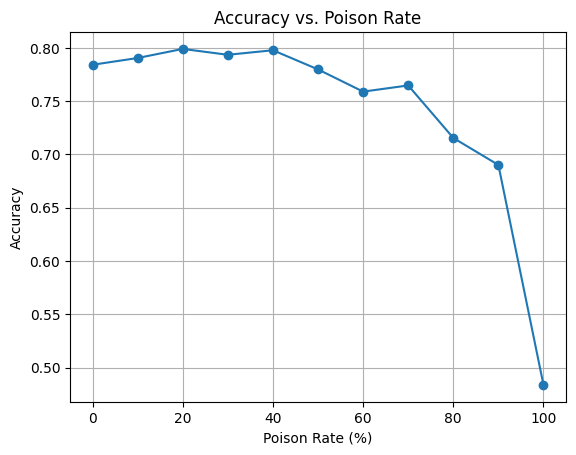

In [9]:
# 绘制图形
plt.plot(poison_rates, accuracy_list, marker='o')

# 设置标题和坐标轴标签
plt.title('Accuracy vs. Poison Rate')
plt.xlabel('Poison Rate (%)')
plt.ylabel('Accuracy')

# 显示网格线
plt.grid(True)

# 显示图形
plt.show()